Cargando dataset 'Maysee/tiny-imagenet'...
Dataset cargado.
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Mostrando imagen de ejemplo (índice 2002 del conjunto 'train'):


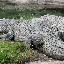

In [2]:
# Importaciones necesarias
from datasets import load_dataset
from transformers import pipeline
import ray
import time 
# Carga del dataset
print("Cargando dataset 'Maysee/tiny-imagenet'...")
tiny_imagenet = load_dataset('Maysee/tiny-imagenet')
print("Dataset cargado.")
print(tiny_imagenet)

# Accedermosa una imagen de ejemplo
img_example = tiny_imagenet['train'][2002]['image']
print("\nMostrando imagen de ejemplo (índice 2002 del conjunto 'train'):")
img_example # En Jupyter, esto mostrará la imagen --break-system-packages

In [3]:
# Cargamos el modelo de clasificación de imágenes
print("Cargando el clasificador de imágenes 'image-classification'...")
clf = pipeline("image-classification", framework="pt") # "pt" es para PyTorch
print("Clasificador cargado.")

print("\nClasificando la imagen de ejemplo:")
classification_result = clf(img_example)
print(classification_result)

# Función auxiliar para obtener la mejor clase y puntuación
def get_best_class_and_score(classifier, pil_image):
    """
    Clasifica una imagen y retorna la tupla (clase, puntuación) de la mejor predicción.
    """
    predictions = classifier(pil_image)
    if predictions: # Asegurarse de que hay predicciones
        best_prediction = predictions[0] # La primera es la de mayor puntuación
        return (best_prediction['label'], best_prediction['score'])
    return (None, 0.0) # En caso de no haber predicciones

# Probamos la función auxiliar
best_class, best_score = get_best_class_and_score(clf, img_example)
print(f"\nMejor clasificación para la imagen de ejemplo: Clase='{best_class}', Puntuación={best_score:.4f}")

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


Cargando el clasificador de imágenes 'image-classification'...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cpu


Clasificador cargado.

Clasificando la imagen de ejemplo:
[{'label': 'African crocodile, Nile crocodile, Crocodylus niloticus', 'score': 0.7086568474769592}, {'label': 'American alligator, Alligator mississipiensis', 'score': 0.27417102456092834}, {'label': 'alligator lizard', 'score': 0.0010881631169468164}, {'label': 'frilled lizard, Chlamydosaurus kingi', 'score': 0.0005320230266079307}, {'label': 'rock python, rock snake, Python sebae', 'score': 0.0005290994886308908}]

Mejor clasificación para la imagen de ejemplo: Clase='African crocodile, Nile crocodile, Crocodylus niloticus', Puntuación=0.7087


In [4]:
# Selección de las 250 imágenes a procesar
image_indices = range(0, 10000, 40)
images_to_classify_pil = [tiny_imagenet['train'][i]['image'] for i in image_indices]
print(f"Se procesarán {len(images_to_classify_pil)} imágenes.")

Se procesarán 250 imágenes.


In [ ]:
%%time
# Versión A: Secuencial

print("Versión A: Recargando dataset y modelo...")
current_dataset_a = load_dataset('Maysee/tiny-imagenet', trust_remote_code=True) # Es buena práctica especificar trust_remote_code
current_images_a = [current_dataset_a['train'][i]['image'] for i in range(0, 10000, 40)]
current_clf_a = pipeline("image-classification", framework="pt")
print("Dataset y modelo recargados para Versión A.")

results_a = []
print("Iniciando clasificación secuencial...")
for img_pil in current_images_a:
    best_class, best_score = get_best_class_and_score(current_clf_a, img_pil)
    results_a.append((best_class, best_score))

print(f"Clasificación secuencial completada. {len(results_a)} imágenes procesadas.")


Versión A: Recargando dataset y modelo...


No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cpu


Dataset y modelo recargados para Versión A.
Iniciando clasificación secuencial...
Clasificación secuencial completada. 250 imágenes procesadas.
CPU times: user 5min 31s, sys: 12.8 s, total: 5min 43s
Wall time: 46.5 s


In [ ]:
%%time
# Versión B: Paralela con Tareas Remotas de Ray

# Recargamos el dataset y el modelo
print("Versión B: Recargando dataset y modelo...")
current_dataset_b = load_dataset('Maysee/tiny-imagenet', trust_remote_code=True)
current_images_b_pil = [current_dataset_b['train'][i]['image'] for i in range(0, 10000, 40)]
current_clf_b = pipeline("image-classification", framework="pt")
print("Dataset y modelo recargados para Versión B.")


# Definmos la tarea remota de Ray
@ray.remote
def inference_task(classifier, image_pil):
    # Esta función se ejecuta como una tarea remota de Ray
    return get_best_class_and_score(classifier, image_pil)

# Almacenar el clasificador en el object store de Ray
clf_ref_b = ray.put(current_clf_b)

print("Iniciando clasificación paralela con tareas de Ray...")
# Lanzamos las tareas remotas
# Pasamos la referencia al clasificador y cada imagen individualmente
result_refs_b = [inference_task.remote(clf_ref_b, img_pil) for img_pil in current_images_b_pil]

# resultados
results_b = ray.get(result_refs_b)

print(f"Clasificación con tareas de Ray completada. {len(results_b)} imágenes procesadas.")

del clf_ref_b

2025-05-21 18:00:28,205	INFO worker.py:1888 -- Started a local Ray instance.


Versión B: Recargando dataset y modelo...


No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cpu


Dataset y modelo recargados para Versión B.
Iniciando clasificación paralela con tareas de Ray...


(inference_task pid=7597) 2025-05-21 18:00:43.190547: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(inference_task pid=7588) 2025-05-21 18:00:43.276685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(inference_task pid=7597) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(inference_task pid=7597) E0000 00:00:1747850443.440657    7597 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(inference_task pid=7588) E0000 00:00:1747850443.448330    7588 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting t

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 2ae47157c3abb92407d05eaa49b99761e12c895301000000 Worker ID: ed640f09c85b162bb8624f89451c81c7d773e32ac854b477dbd4f2cc Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17.0.2 Worker port: 43617 Worker PID: 7597 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: e80013b9d05f12cd4045b4c86eda3de20fe6898201000000 Worker ID: 0eb8abb8c90e9872bce235b65b03f7c04050bb9c9f0ca27f996e0594 Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17

(raylet) [2025-05-21 18:01:49,311 E 7508 7508] (raylet) node_manager.cc:3287: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a, IP: 172.17.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.17.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(inference_task pid=7598) /usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requ

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 6e78c6086208d3d9c9bfc5ee6c8b168716c4653801000000 Worker ID: b9e5a1372ae8eaf97cd3379108261a2e8c7263fe2132e5ae95bf482f Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17.0.2 Worker port: 34169 Worker PID: 7589 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 68b9375466619fa436c569e16b5ebb30fc352b2401000000 Worker ID: dd5c42a61666fb45421f3078a248ec51f0ea517f9ba292e8f129c5c5 Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17

(raylet) [2025-05-21 18:02:00,374 E 7508 7508] (raylet) worker_pool.cc:586: Some workers of the worker process(8640) have not registered within the timeout. The process is still alive, probably it's hanging during start.
(inference_task pid=8657) 2025-05-21 18:02:22.188489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(inference_task pid=8655) 2025-05-21 18:02:22.694438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(inference_task pid=8655) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(inference_task pid=8655) E0000 00:00:1747850542.876761    8655 cuda_dnn.cc:8579] Unable to register cuDNN fac

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 4f4172517cd43da315de153d915a5d784c795b7b01000000 Worker ID: 82138e7b531625639990981c1d89944728f35f4e26a43c6eb0244f4b Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17.0.2 Worker port: 41835 Worker PID: 10162 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 525e615894d75050abb0739f204dce4baffdf9c801000000 Worker ID: e9e450d5e6c2e23835ab65825c5d9877d40b8cae1a293d2cfa07bfa5 Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.1

(raylet) [2025-05-21 18:02:57,446 E 7508 7508] (raylet) node_manager.cc:3287: 9 Workers (tasks / actors) killed due to memory pressure (OOM), 1 Workers crashed due to other reasons at node (ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a, IP: 172.17.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.17.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(inference_task pid=10162) /usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas req

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 0c0178511653498e27e91c16dc5c7e8b174780f501000000 Worker ID: d510cc4416940631022531f7da40a3441fce04f5833af9e929ba8758 Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17.0.2 Worker port: 34951 Worker PID: 8642 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details:  [repeated 2x across cluster]
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 0992e81e2e196ad37941fa1e0a14e317c0a27b4a01000000 Worker ID: 3aeaf2fa9abe814bdad486124d01618efa5b317fb1342790ee906ac4 Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b3589

(inference_task pid=11880) 2025-05-21 18:03:43.437687: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(inference_task pid=11398) /usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed). [repeated 6x across cluster]
(inference_task pid=11398)   from pandas.core import ( [repeated 6x across cluster]


(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 2b544e8b20e06aa0217bc3194bd7a08c2474bb7d01000000 Worker ID: 04ef7618c3a7c692087a14ecccc1083b7e8884627c54a51786547b5e Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17.0.2 Worker port: 41505 Worker PID: 8669 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 


(raylet) [2025-05-21 18:04:01,811 E 7508 7508] (raylet) node_manager.cc:3287: 9 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a, IP: 172.17.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.17.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(inference_task pid=11880) 2025-05-21 18:04:03.127405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unabl

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 6590bf94ccd4b4e5ed3ce01448ad159bb062ed5b01000000 Worker ID: d398e36cd45faf3a7659bd38b700dbd27e8a9e675a96816fec5c03d9 Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17.0.2 Worker port: 41765 Worker PID: 12572 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 


(inference_task pid=12919) 2025-05-21 18:04:12.347271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 5x across cluster]
(inference_task pid=12905) /usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed). [repeated 4x across cluster]
(inference_task pid=12905)   from pandas.core import ( [repeated 4x across cluster]
(inference_task pid=12906) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR [repeated 4x across cluster]
(inference_task pid=12906) E0000 00:00:1747850652.424016   12906 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered [repeated 4x across cluster]
(inference_task pid=12906) E0000 00:00

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 4816786f48f195a1963693ef20aeb1a700c709e801000000 Worker ID: 138bae7e3160fa293f35e4bdeeabd976d31aac54b8a1a86734d4a0eb Node ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a Worker IP address: 172.17.0.2 Worker port: 33171 Worker PID: 12905 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
Clasificación con tareas de Ray completada. 250 imágenes procesadas.
CPU times: user 3.23 s, sys: 54.4 s, total: 57.6 s
Wall time: 4min 6s


(raylet) [2025-05-21 18:05:27,896 E 7508 7508] (raylet) node_manager.cc:3287: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a, IP: 172.17.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.17.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(pid=13803) 2025-05-21 18:05:43.585124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see sl

(InferenceEngine pid=13803) Actor InferenceEngine inicializando. load_images=True


(InferenceEngine pid=13808) Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
(InferenceEngine pid=13813) Device set to use cpu


(InferenceEngine pid=13805) Actor cargando dataset 'Maysee/tiny-imagenet'...
(InferenceEngine pid=13808) Actor: dataset cargado.
(InferenceEngine pid=13808) Actor InferenceEngine inicializado.
(InferenceEngine pid=13812) Actor InferenceEngine inicializando. load_images=True [repeated 15x across cluster]
(InferenceEngine pid=13803) Actor cargando dataset 'Maysee/tiny-imagenet'... [repeated 14x across cluster]


(InferenceEngine pid=13812) No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224). [repeated 15x across cluster]
(InferenceEngine pid=13812) Using a pipeline without specifying a model name and revision in production is not recommended. [repeated 15x across cluster]
(InferenceEngine pid=13806) Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`. [repeated 15x across cluster]
(InferenceEngine pid=13803) Device set to use cpu [repeated 14x across cluster]


(InferenceEngine pid=13803) Actor: dataset cargado. [repeated 14x across cluster]
(InferenceEngine pid=13803) Actor InferenceEngine inicializado. [repeated 14x across cluster]
(InferenceEngine pid=13806) Actor cargando dataset 'Maysee/tiny-imagenet'...


(raylet) [2025-05-21 18:06:27,902 E 7508 7508] (raylet) node_manager.cc:3287: 10 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a, IP: 172.17.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.17.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(InferenceEngine pid=13806) Device set to use cpu
(pid=15045) 2025-05-21 18:07:47.926011: I tensorflow/core/util/port.cc:1

(InferenceEngine pid=15053) Actor InferenceEngine inicializando. load_images=False


(InferenceEngine pid=15045) No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
(InferenceEngine pid=15045) Using a pipeline without specifying a model name and revision in production is not recommended.
(pid=15052) /usr/local/lib/python3.11/dist-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed). [repeated 15x across cluster]
(pid=15052)   from pandas.core import ( [repeated 15x across cluster]
(InferenceEngine pid=15045) Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
(InferenceEngine pid=15045) Device set to use cpu


(InferenceEngine pid=15053) Actor InferenceEngine inicializado.


(raylet) [2025-05-21 18:08:27,907 E 7508 7508] (raylet) node_manager.cc:3287: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 5245c351d8875657ab602cd0b6baee5a0531dc033e842ef1b358919a, IP: 172.17.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.17.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(InferenceEngine pid=15052) No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://h

In [7]:
@ray.remote
class InferenceEngine:
    def __init__(self, load_images=True):
        print(f"Actor InferenceEngine inicializando. load_images={load_images}")
        # Cada actor carga su propia instancia del clasificador
        self.classifier = pipeline("image-classification")
        self.dataset_train = None
        if load_images:
            # Cada actor carga el dataset si es necesario
            print("Actor cargando dataset 'Maysee/tiny-imagenet'...")
            self.dataset_train = load_dataset('Maysee/tiny-imagenet', trust_remote_code=True)['train']
            print("Actor: dataset cargado.")
        else:
            self.dataset_train = None
        print("Actor InferenceEngine inicializado.")

    def classify_image_by_index(self, image_index):
        """
        Clasifica una imagen del dataset interno del actor, especificada por su índice.
        """
        # print(f"Actor clasificando imagen por índice: {image_index}")
        if self.dataset_train is None:
            return ("Error: El dataset no está cargado en este actor o índice fuera de rango", -1.0)
        
        try:
            # Extraer la imagen PIL del dataset del actor
            image_pil = self.dataset_train[image_index]['image']
            return get_best_class_and_score(self.classifier, image_pil)
        except IndexError:
            return (f"Error: Índice {image_index} fuera de rango para el dataset del actor", -1.0)
        except Exception as e:
            return (f"Error al procesar imagen por índice {image_index}: {str(e)}", -1.0)

    def classify_image_object(self, image_pil_object):
        """
        Clasifica un objeto de imagen PIL pasado como parámetro.
        """
        # print("Actor clasificando objeto de imagen PIL...")
        if image_pil_object is None:
            return ("Error: Objeto de imagen PIL es None", -1.0)
        return get_best_class_and_score(self.classifier, image_pil_object)

    def get_classifier_pid(self): # Método de ayuda para depuración (opcional)
        import os
        return os.getpid()

In [ ]:
%%time
# Versión C1: Actores con dataset en memoria en cada actor

# Número de actores = número de CPUs disponibles (o un número fijo si prefieres)
num_actors = ray.available_resources().get("CPU", 1) # Obtiene los CPUs lógicos
num_actors = int(num_actors) if num_actors else 2 # Usar al menos 2 si no se detectan CPUs
print(f"Versión C1: Creando {num_actors} actores. Cada actor cargará el dataset.")

# Creamos los actores, cada uno cargará el dataset
actors_c1 = [InferenceEngine.remote(load_images=True) for _ in range(num_actors)]
print(f"{len(actors_c1)} actores creados para Versión C1.")

image_indices_c1 = list(range(0, 10000, 40)) 

results_c1 = []
result_refs_c1 = []
print("Iniciando clasificación con actores (C1)...")

# Asignamos trabajo de forma rotatoria (round-robin) a los actores
for i, image_idx in enumerate(image_indices_c1):
    actor_index = i % num_actors
    result_refs_c1.append(actors_c1[actor_index].classify_image_by_index.remote(image_idx))

results_c1 = ray.get(result_refs_c1)

print(f"Clasificación con actores (C1) completada. {len(results_c1)} imágenes procesadas.")

# Destruimos los actores para liberar recursos
print("Destruyendo actores de Versión C1...")
for actor in actors_c1:
    ray.kill(actor)
print("Actores de Versión C1 destruidos.")


Versión C1: Creando 16 actores. Cada actor cargará el dataset.
16 actores creados para Versión C1.
Iniciando clasificación con actores (C1)...
Clasificación con actores (C1) completada. 250 imágenes procesadas.
Destruyendo actores de Versión C1...
Actores de Versión C1 destruidos.
CPU times: user 1.07 s, sys: 7.26 s, total: 8.33 s
Wall time: 1min 41s


In [ ]:
%%time
# Versión C2: Actores sin dataset en memoria (dataset en driver)

# Recargamos el dataset en el driver
print("Versión C2: Recargando dataset en el driver...")
current_dataset_c2 = load_dataset('Maysee/tiny-imagenet', trust_remote_code=True)
images_to_classify_pil_c2 = [current_dataset_c2['train'][i]['image'] for i in range(0, 10000, 40)]
print("Dataset cargado en el driver para Versión C2.")

num_actors_c2 = int(ray.available_resources().get("CPU", 1) or 2)
print(f"Versión C2: Creando {num_actors_c2} actores. Los actores NO cargarán el dataset.")

actors_c2 = [InferenceEngine.remote(load_images=False) for _ in range(num_actors_c2)]
print(f"{len(actors_c2)} actores creados para Versión C2.")

results_c2 = []
result_refs_c2 = []
print("Iniciando clasificación con actores (C2)...")

# Asignamos trabajo de forma rotatoria
for i, image_pil_obj in enumerate(images_to_classify_pil_c2):
    actor_index = i % num_actors_c2
    result_refs_c2.append(actors_c2[actor_index].classify_image_object.remote(image_pil_obj))

results_c2 = ray.get(result_refs_c2)

print(f"Clasificación con actores (C2) completada. {len(results_c2)} imágenes procesadas.")
# print("\nPrimeros 5 resultados de la Versión C2:")
# for i in range(min(5, len(results_c2))):
# print(f"  {results_c2[i]}")

# Y destruimos los actores
print("Destruyendo actores de Versión C2...")
for actor in actors_c2:
    ray.kill(actor)
print("Actores de Versión C2 destruidos.")


Versión C2: Recargando dataset en el driver...


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/Maysee/tiny-imagenet/resolve/main/README.md
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/Maysee/tiny-imagenet/resolve/main/README.md
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/Maysee/tiny-imagenet/resolve/main/README.md
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/Maysee/tiny-imagenet/resolve/main/README.md
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/Maysee/tiny-imagenet/resolve/main/README.md
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/Maysee/tiny-imagenet/resolve/main/README.md
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/Maysee/tiny-imagenet/resolve/5a77092c28e51558c5586e9c5eb71a7e17a

Dataset cargado en el driver para Versión C2.
Versión C2: Creando 16 actores. Los actores NO cargarán el dataset.
16 actores creados para Versión C2.
Iniciando clasificación con actores (C2)...
Clasificación con actores (C2) completada. 250 imágenes procesadas.
Destruyendo actores de Versión C2...
Actores de Versión C2 destruidos.
CPU times: user 1 s, sys: 442 ms, total: 1.44 s
Wall time: 1min 42s


## CONCLUISION

En este entorno con limitaciones de memoria evidentes (que causan OOMs), la Versión A (secuencial) resultó ser la más rápida (46.5 s) porque evitó la sobrecarga y los fallos de un sistema distribuido bajo presión.
La Versión B (tareas) fue la menos eficiente debido a la alta sobrecarga por tarea y los masivos errores OOM.
Las Versiones C1 y C2 (actores) ofrecieron un rendimiento mucho mejor que B y similar entre sí (alrededor de 1m 41s). Los actores son más eficientes que las tareas para este tipo de trabajo porque el modelo (pipeline) se carga una sola vez por actor, en lugar de potencialmente en cada tarea. 
Entre C1 y C2, C2 (dataset en driver) parece ser un diseño más robusto para la memoria en este escenario, ya que evitó los OOM en los actores (aunque C1 solo reportó uno). Si el dataset fuera mucho más grande o el número de actores mayor, la ventaja de C2 en términos de memoria sería más pronunciada. La pequeña diferencia de tiempo entre C1 y C2 podría estar influenciada por el OOM en C1 y los retrasos de descarga en C2.